# Introduction
This notebook shows how to use TimesFM with finetuning. 

In order to perform finetuning, you need to create the Pytorch Dataset in a proper format. The example of the Dataset is provided below.
The finetuning code can be found in timesfm.finetuning_torch.py. This notebook just imports the methods from finetuning

In [1]:
%load_ext autoreload
%autoreload 2

from time import time
import os
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.multiprocessing as mp
import sys
sys.path.append("../src/finetuning")
sys.path.append("../src/timesfm")
sys.path.append("../../TimeseriesPrediction")


from finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder

from pipeline_o1 import load_BTC_data



/home/fenrir/mambaforge/envs/timesfm_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0].


### Dataset Creation

In [2]:
class TimeSeriesDataset(Dataset):
    """Dataset for time series data compatible with TimesFM."""

    def __init__(self,
               series: np.ndarray,
               context_length: int,
               horizon_length: int,
               freq_type: int = 0):
        """
        Initialize dataset.

        Args:
            series: Time series data
            context_length: Number of past timesteps to use as input
            horizon_length: Number of future timesteps to predict
            freq_type: Frequency type (0, 1, or 2)
        """
        if freq_type not in [0, 1, 2]:
            raise ValueError("freq_type must be 0, 1, or 2")

        self.series = series
        self.context_length = context_length
        self.horizon_length = horizon_length
        self.freq_type = freq_type
        self._prepare_samples()

    def _prepare_samples(self) -> None:
        """Prepare sliding window samples from the time series."""
        self.samples = []
        total_length = self.context_length + self.horizon_length

        for start_idx in range(0, len(self.series) - total_length + 1):
            end_idx = start_idx + self.context_length
            x_context = self.series[start_idx:end_idx]
            x_future = self.series[end_idx:end_idx + self.horizon_length]
            
            # Normalizza ogni finestra separatamente
            mean = np.mean(x_context)
            std = np.std(x_context)
            if std == 0:  # Evita divisioni per zero
                std = 1
            x_context = (x_context - mean) / std
            x_future = (x_future - mean) / std  # Usa la stessa normalizzazione per il target
            self.samples.append((x_context, x_future))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        x_context, x_future = self.samples[index]

        x_context = torch.tensor(x_context, dtype=torch.float32)
        x_future = torch.tensor(x_future, dtype=torch.float32)

        input_padding = torch.zeros_like(x_context)
        freq = torch.tensor([self.freq_type], dtype=torch.long)

        return x_context, input_padding, freq, x_future

def prepare_datasets(series: np.ndarray,
                     context_length: int,
                     horizon_length: int,
                     freq_type: int = 0,
                     train_split: float = 0.7) -> Tuple[Dataset, Dataset]:
    """
    Prepare training and validation datasets from time series data.

    Args:
        series: Input time series data
        context_length: Number of past timesteps to use
        horizon_length: Number of future timesteps to predict
        freq_type: Frequency type (0, 1, or 2)
        train_split: Fraction of data to use for training

    Returns:
        Tuple of (train_dataset, val_dataset)
    """
    #mean = np.mean(series)
    #std = np.std(series)
    #series = (series - mean) / std

    train_size = int(len(series) * train_split)
    train_data = series[:train_size]
    val_data = series[train_size:]

    # Create datasets with specified frequency type
    train_dataset = TimeSeriesDataset(train_data,
                                    context_length=context_length,
                                    horizon_length=horizon_length,
                                    freq_type=freq_type)

    val_dataset = TimeSeriesDataset(val_data,
                                  context_length=context_length,
                                  horizon_length=horizon_length,
                                  freq_type=freq_type)

    return train_dataset, val_dataset


from sum_time_series import parallel_generate_series

def create_series():
    series_length = 36000
    n_series_range = range(300, 2201, 600)
    num_rep = 1
    exp = -1.0001
    freq_range = (0.000001, 500)
    serie_generate, _, _ = parallel_generate_series(n_series_range, num_rep, series_length, 1, exp, freq_range, 1)

    return serie_generate

In [3]:
serie_generate = create_series()
print(serie_generate.keys())

dict_keys([300, 900, 1500, 2100])


In [4]:
s = serie_generate[900][0]
s.shape, type(s)

((36000,), numpy.ndarray)

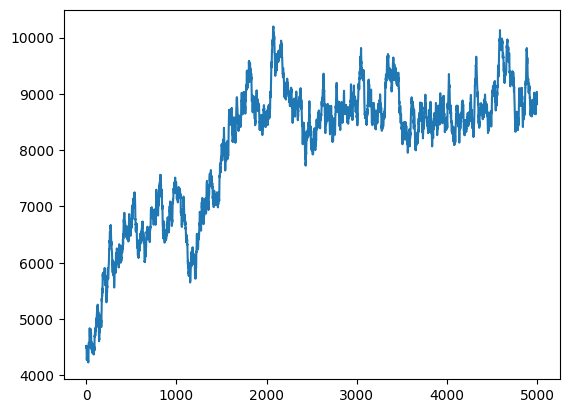

In [5]:
plt.plot(s[15000:20000])

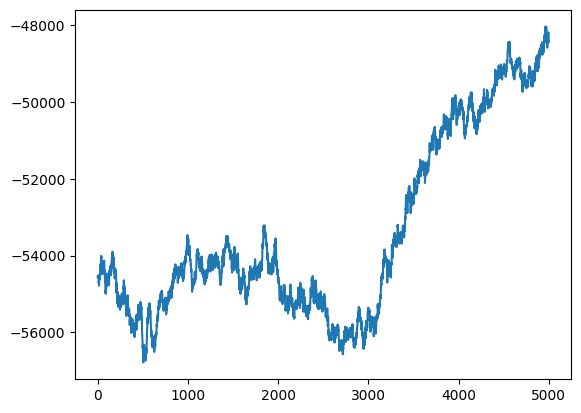

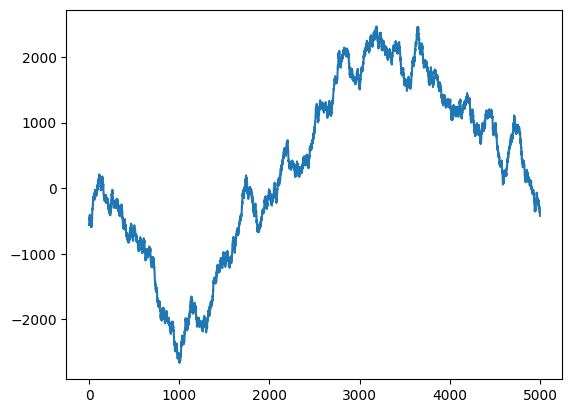

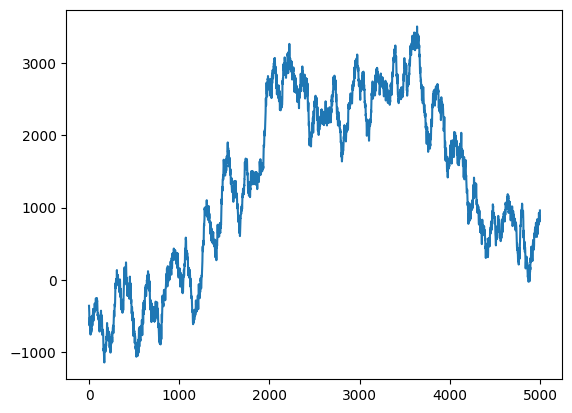

### carico BTC

In [17]:
ts_path = 'resampled32k_BTC.csv'
serie, time_index = load_BTC_data(ts_path)
s = serie.numpy()

([<matplotlib.lines.Line2D at 0x7ff27c0d8f10>], (32779,), numpy.ndarray)

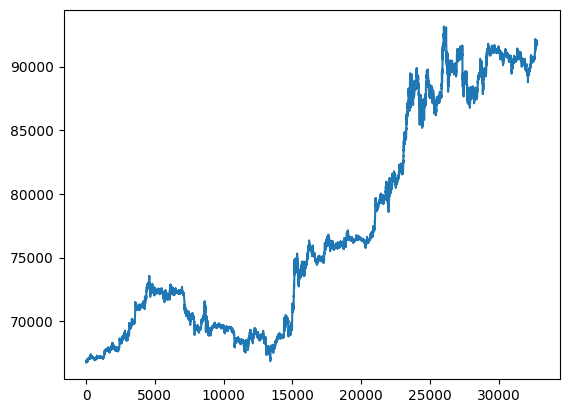

In [18]:
plt.plot(s), s.shape, type(s)

### Model Creation

In [6]:
#def get_model(load_weights: bool = False):
device = "cuda" if torch.cuda.is_available() else "cpu"
repo_id = "google/timesfm-2.0-500m-pytorch"
hparams = TimesFmHparams(
  backend=device,
  per_core_batch_size=32,
  horizon_len=10,
  num_layers=50,
  use_positional_embedding=False,
  context_len=512,  # Context length can be anything up to 2048 in multiples of 32
)
tfm = TimesFm(hparams=hparams, checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

model = PatchedTimeSeriesDecoder(tfm._model_config)

checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
print(f"Loading {checkpoint_path}")
loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
model.load_state_dict(loaded_checkpoint)


Fetching 5 files: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18078.90it/s]


Loading /home/fenrir/.cache/huggingface/hub/models--google--timesfm-2.0-500m-pytorch/snapshots/777ca63ff7d647a4181ebe0efe1f94725e197ae1/torch_model.ckpt


<All keys matched successfully>

## Start train

In [9]:
#def single_gpu_example():
"""Basic example of finetuning TimesFM on stock data."""
#model, hparams, tfm_config = get_model(load_weights=True)
config = FinetuningConfig(horizon_len=10,
                        batch_size=256,
                        num_epochs=100,
                        learning_rate=1e-4,
                        use_wandb=False,
                        freq_type=1,
                        log_every_n_steps=10,
                        val_check_interval=0.5,
                        use_quantile_loss=False)

train_dataset, val_dataset = prepare_datasets(s, context_length=512, horizon_length=10, freq_type=config.freq_type)

In [10]:
config

FinetuningConfig(horizon_len=10, batch_size=256, num_epochs=100, learning_rate=0.0001, weight_decay=0.01, freq_type=1, use_quantile_loss=False, quantiles=None, device='cuda', distributed=False, gpu_ids=[0], master_port='12358', master_addr='localhost', use_wandb=False, wandb_project='timesfm-finetuning', log_every_n_steps=10, val_check_interval=0.5)

In [ ]:
finetuner = TimesFMFinetuner(model, config)
print("\nStarting finetuning...")
start = time()
results = finetuner.finetune(train_dataset=train_dataset, val_dataset=val_dataset)
print("\nFinetuning completed!")
end = time()


Starting finetuning...
Starting training for 100 epochs...
Training samples: 24679
Validation samples: 10279
[Epoch 1] Train Loss: 0.1676 | Val Loss: 0.1342
[Epoch 2] Train Loss: 436.3923 | Val Loss: 0.4472
[Epoch 3] Train Loss: 0.2628 | Val Loss: 0.1803
[Epoch 4] Train Loss: 0.1787 | Val Loss: 0.1663
[Epoch 5] Train Loss: 0.1676 | Val Loss: 0.1590
[Epoch 6] Train Loss: 0.1626 | Val Loss: 0.1505
[Epoch 7] Train Loss: 0.1588 | Val Loss: 0.1494
[Epoch 8] Train Loss: 0.1605 | Val Loss: 0.1506
[Epoch 9] Train Loss: 0.1586 | Val Loss: 0.1482
[Epoch 10] Train Loss: 0.1580 | Val Loss: 0.1462
[Epoch 11] Train Loss: 0.1581 | Val Loss: 0.1531
[Epoch 12] Train Loss: 0.1673 | Val Loss: 0.1864
[Epoch 13] Train Loss: 0.1599 | Val Loss: 0.1558
[Epoch 14] Train Loss: 0.1522 | Val Loss: 0.1921
[Epoch 15] Train Loss: 0.1585 | Val Loss: 0.1462
[Epoch 16] Train Loss: 0.1515 | Val Loss: 0.1545
[Epoch 17] Train Loss: 0.1564 | Val Loss: 0.1522
[Epoch 18] Train Loss: 0.1527 | Val Loss: 0.1430
[Epoch 19] Trai

In [11]:
print(f"Tempo impiegato {round((end-start)/60, 2)} minuti. ({round((end-start)/3660, 1)} ore)")

Tempo impiegato 384.61 minuti. (6.3 ore)


In [29]:
plot_predictions(
  model=model,
  val_dataset=val_dataset,
  save_path="timesfm_predictions_300.png",
)

TypeError: plot_predictions() got an unexpected keyword argument 'val_dataset'

In [13]:
results['history'].keys()

dict_keys(['train_loss', 'val_loss', 'learning_rate'])

In [12]:
import pickle
with open('results_900_normalized.pkl', "wb") as file:
    pickle.dump(results, file)

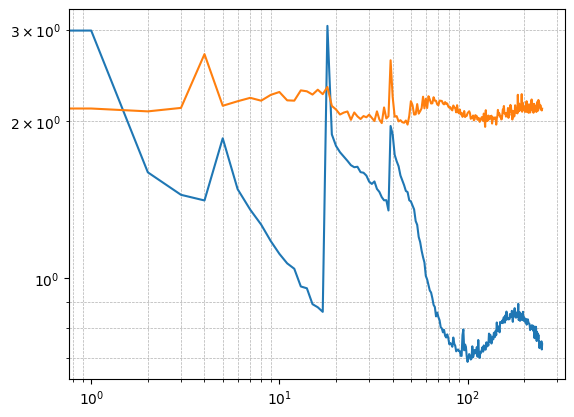

In [13]:
plt.plot(results['history']['train_loss'])
plt.plot(results['history']['val_loss'])
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='minor', linestyle='--', linewidth=0.5)

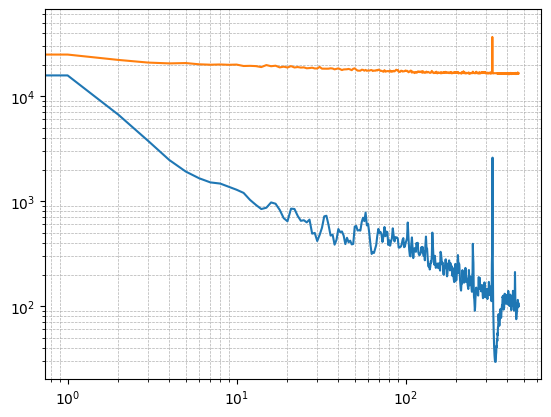

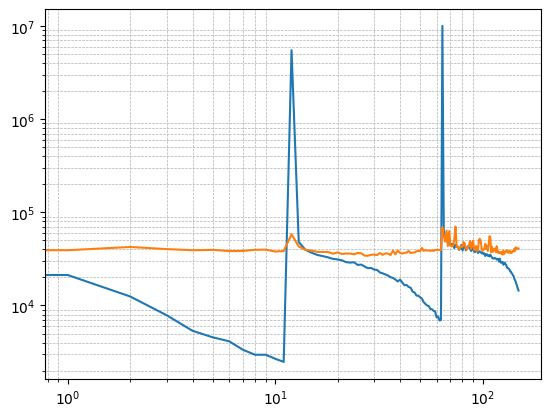

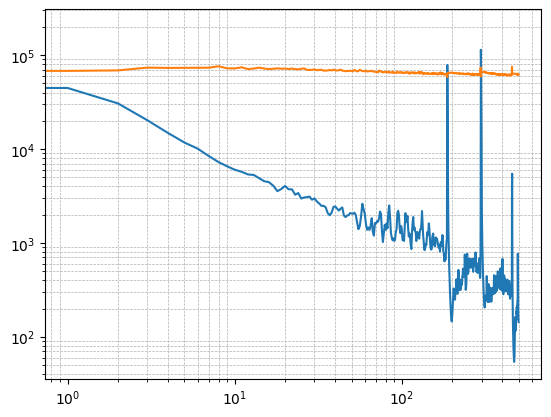

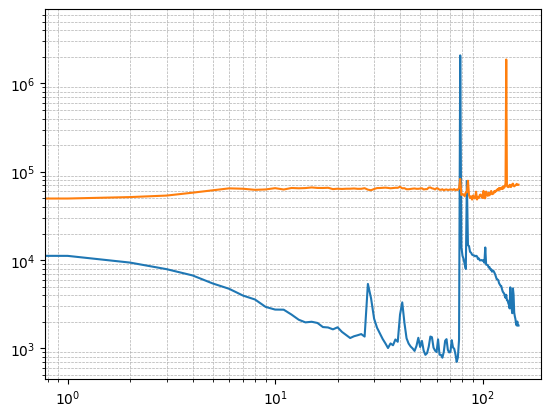

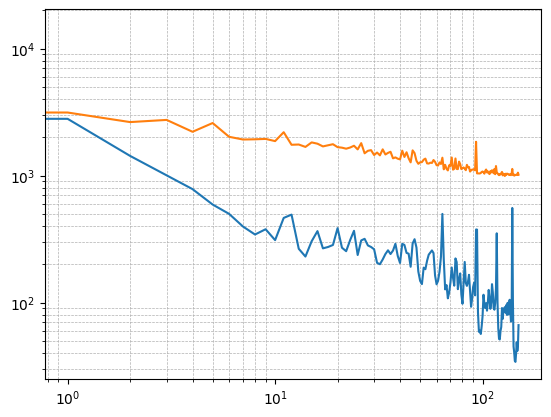

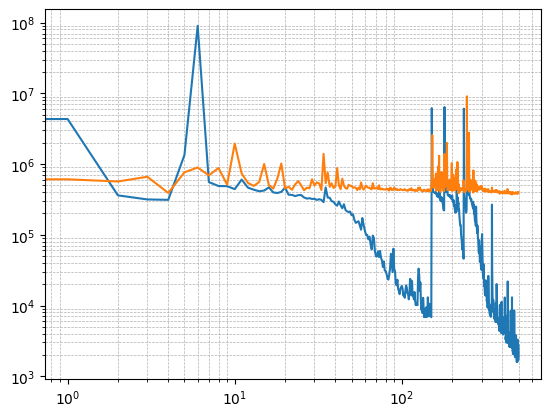

## Plots

In [14]:
#import sys
#from testing import plot_predictions

In [20]:
#plot_predictions(val_dataset, model, num_samples=10)

In [25]:
def plot_predictions(
    idx:int,
model: TimesFm,
val_dataset: Dataset,
save_path: Optional[str] = "predictions.png",
) -> None:
    """
    Plot model predictions against ground truth for a batch of validation data.
    
    Args:
      model: Trained TimesFM model
      val_dataset: Validation dataset
      save_path: Path to save the plot
    """
    
    
    model.eval()
    
    x_context, x_padding, freq, x_future = val_dataset[idx]
    x_context = x_context.unsqueeze(0)  # Add batch dimension
    x_padding = x_padding.unsqueeze(0)
    freq = freq.unsqueeze(0)
    x_future = x_future.unsqueeze(0)
    
    device = next(model.parameters()).device
    x_context = x_context.to(device)
    x_padding = x_padding.to(device)
    freq = freq.to(device)
    x_future = x_future.to(device)
    
    with torch.no_grad():
        predictions = model(x_context, x_padding.float(), freq)
        predictions_mean = predictions[..., 0]  # [B, N, horizon_len]
        #last_patch_pred = predictions_mean[:, -1, :]  # [B, horizon_len]        
        
        target_length = x_future.shape[1]
        last_patch_pred = predictions_mean[:, -1, :target_length]

        context_vals = x_context[0].cpu().numpy()
        future_vals = x_future[0].cpu().numpy()
        pred_vals = last_patch_pred[0].cpu().numpy()
    
    context_len = len(context_vals)
    horizon_len = len(future_vals)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(range(context_len),
           context_vals,
           label="Historical Data",
           color="blue",
           linewidth=2)
    
    plt.plot(
      range(context_len, context_len + horizon_len),
      future_vals,
      label="Ground Truth",
      color="green",
      linestyle="--",
      linewidth=2,
    )
    print(f"context_len: {context_len}, horizon_len: {horizon_len}, len pred_vals: {len(pred_vals)}")
    plt.plot(range(context_len, context_len + horizon_len),
           pred_vals,
           label="Prediction",
           color="red",
           linewidth=2)
    
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("TimesFM Predictions vs Ground Truth")
    plt.legend()
    plt.grid(True)
    
    #if save_path:
    #plt.savefig(save_path)
    #print(f"Plot saved to {save_path}")
    
    #plt.close()

In [26]:
len(val_dataset)

10279

context_len: 512, horizon_len: 10, len pred_vals: 10


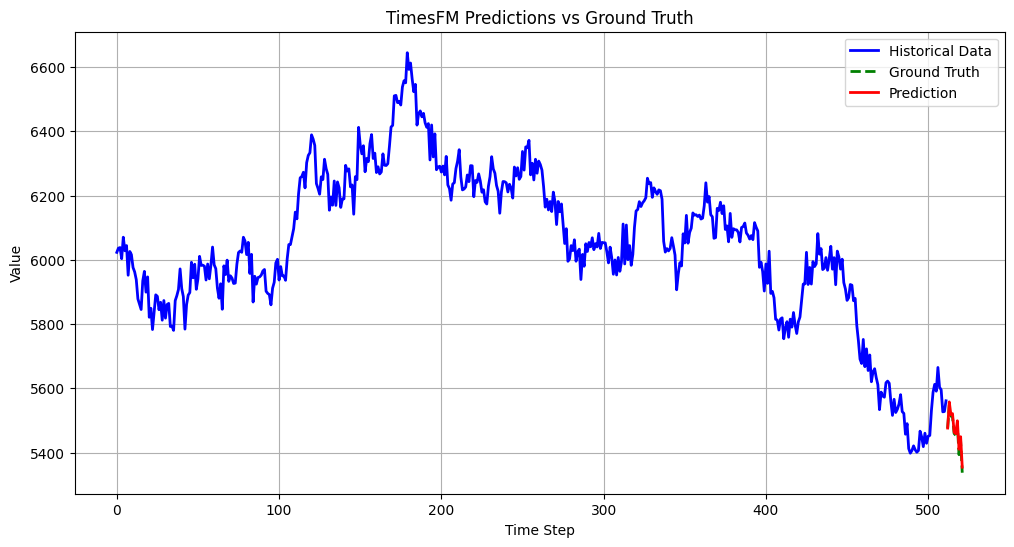

In [29]:
plot_predictions(170, model, val_dataset)

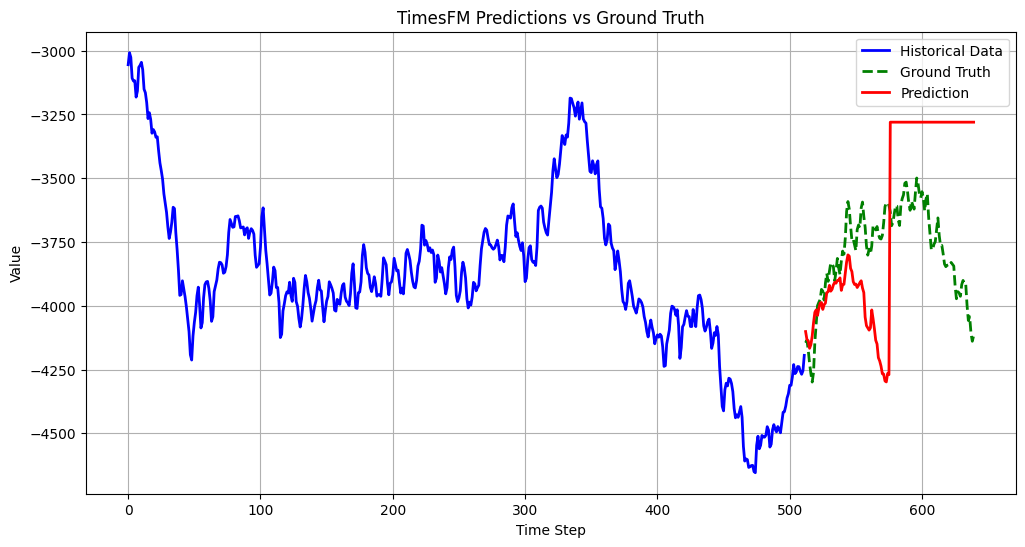

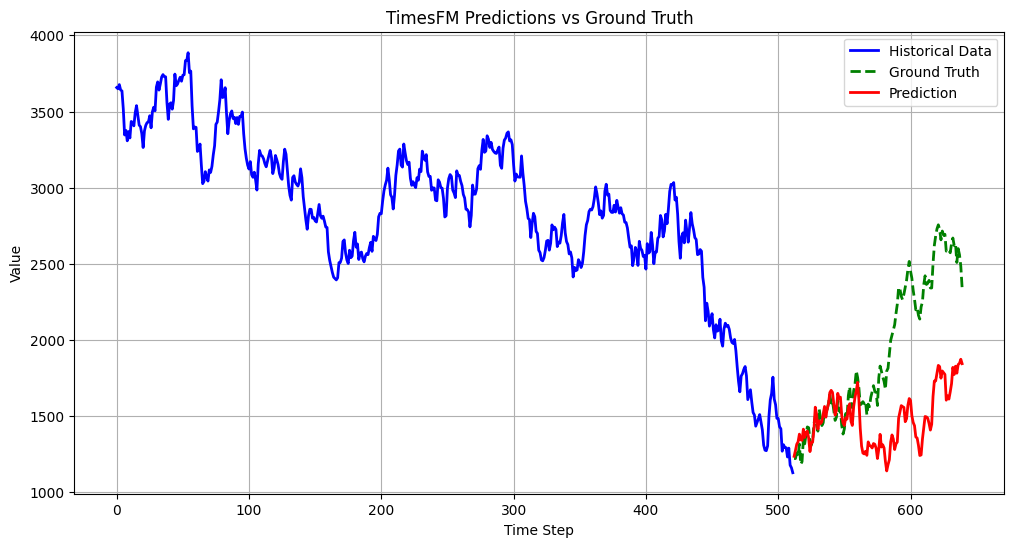